In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import nltk
import string


In [2]:
from youtube_transcript_api import YouTubeTranscriptApi
video_id = 'S4lTtvlFvyk'
transcript = YouTubeTranscriptApi.get_transcript(video_id)

In [3]:




def concat_rows(df):
    # Initialize an empty list to hold the concatenated sentences
    sentences = []
    
    # Initialize a variable to hold the current sentence
    current_sentence = ''
    
    # Iterate through the rows of the dataframe
    for i, row in df.iterrows():
        # Add the text in the current row to the current sentence
        current_sentence += row['text']
        
        # If the current sentence ends with a period, append it to the list of sentences
        if current_sentence.endswith('.'):
            sentences.append(current_sentence)
            current_sentence = ''
        # Otherwise, if the next row does not exist or ends with a period, append the current sentence to the list of sentences
        elif i == len(df) - 1 or df.loc[i+1]['text'].endswith('.'):
            sentences.append(current_sentence)
            current_sentence = ''
        # Otherwise, add a space to the end of the current sentence to separate it from the next row
        else:
            current_sentence += ' '
    
    # Create a new dataframe with the concatenated sentences
    concat_df = pd.DataFrame(sentences, columns=['text'])
    
    return concat_df






In [4]:
df = pd.DataFrame(transcript)

In [29]:
merged_str = df['text'].str.cat(sep=' ')
print(merged_str)

Point number one: When you hear someone longing
for the “good old days,” take it with a grain of salt. Take it with a grain of salt. We live in a great nation and we are rightly
proud of our history. We are beneficiaries of the labor and the
grit and the courage of generations who came before. But I guess it’s part of human nature, especially
in times of change and uncertainty, to want to look backwards and long for some imaginary
past when everything worked, and the economy hummed, and all politicians were wise, and
every child was well-mannered, and America pretty much did whatever it wanted around
the world. Guess what. It ain’t so. The “good old days” weren’t that good. Yes, there have been some stretches in our
history where the economy grew much faster, or when government ran more smoothly. There were moments when, immediately after
World War II, for example, or the end of the Cold War, when the world bent more easily
to our will. But those are sporadic, those moments, those
epis

In [30]:
split_list = merged_str.split('.')
new_df = pd.DataFrame({'text': split_list})

In [31]:
concatenated_df = concat_rows(new_df)

In [32]:
total_characters = concatenated_df['text'].apply(len).sum()
print(f'Total characters is {total_characters}')

Total characters is 20924


In [33]:


# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')



No GPU available, training on CPU; consider making n_epochs very small.


In [34]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/ashfi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ashfi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ashfi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ashfi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [67]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

new_df['cleanText'] = new_df['text'].map(lambda s: preprocess(s))

In [68]:
len(new_df['cleanText'])

256

In [69]:
len(set(new_df['cleanText']))

256

In [70]:
fd =  nltk.FreqDist(new_df['cleanText'])
print(fd)

<FreqDist with 256 samples and 256 outcomes>


In [71]:
fd.tabulate(3)

point number one when you hear someon long for the good old day take it with a grain of salt                                                                 take it with a grain of salt                            we live in a great nation and we are rightli proud of our histori 
                                                                                           1                                                                                            1                                                                                            1 


In [72]:
top_10 = fd.most_common(10)
fdist = pd.Series(dict(top_10))


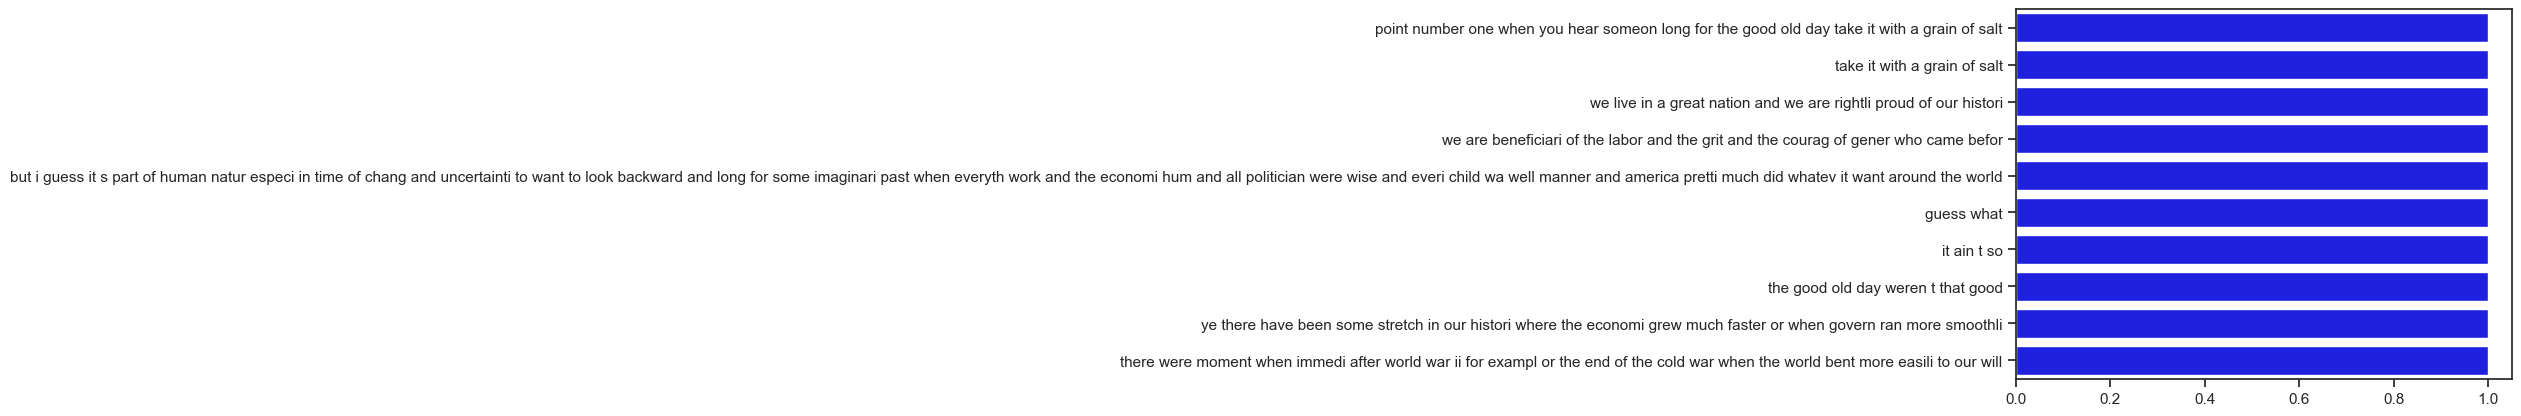

In [73]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.barplot(y=fdist.index, x=fdist.values, color='blue');

In [42]:
random_row = new_df.sample(1)
my_text = random_row['cleanText'].tolist()[0]

In [43]:
def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]

In [47]:
print("1-gram of the sample text: ", extract_ngrams(my_text, 1), '\n')
print("2-gram of the sample text: ", extract_ngrams(my_text, 2), '\n')

1-gram of the sample text:  ['guess'] 

2-gram of the sample text:  [] 



In [48]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [49]:
new_df['polarity'] = new_df['cleanText'].apply(lambda x: analyzer.polarity_scores(x))

In [50]:
new_df = pd.concat(
    [new_df.drop(['polarity'], axis=1),
    new_df['polarity'].apply(pd.Series)], axis=1
)

In [51]:
new_df['sentiment'] = new_df['compound'].apply(lambda x: 'positive' if x > 0 else 'neutral' if x == 0 else 'negative')

In [28]:
g = sns.lineplot(x='duration', y='compound', data=new_df)


g.set(title='Sentiment of Tweets')
g.set(xlabel="Duration")
g.set(ylabel="Sentiment")


g.axhline(0, ls='--', c = 'grey');

ValueError: Could not interpret value `duration` for parameter `x`

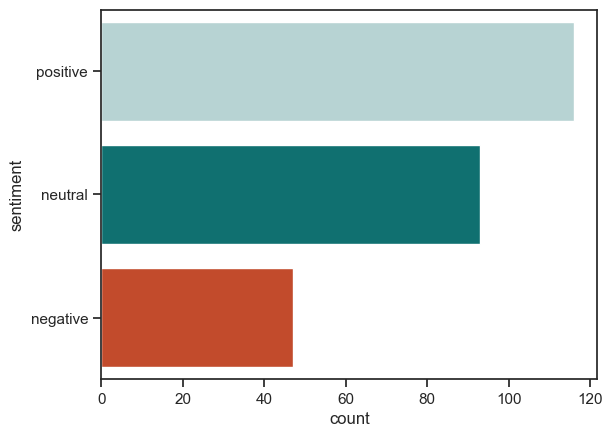

In [54]:
sns.countplot(y='sentiment', 
             data=new_df, 
             palette=['#b2d8d8',"#008080", '#db3d13']
             );

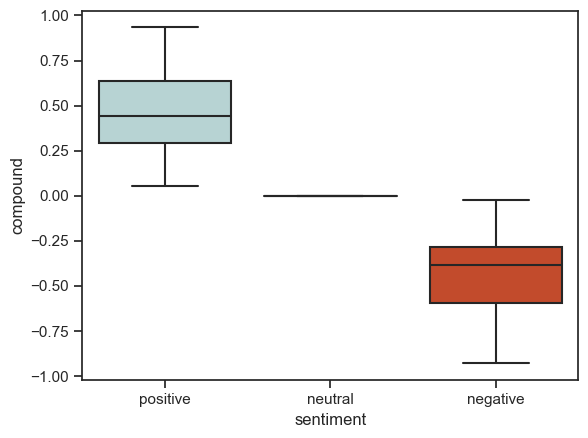

In [55]:
# Boxplot
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=new_df);

In [66]:
from nltk.tokenize import sent_tokenize
import random
corpus = ' '.join([text + '.' for text in new_df['cleanText']])
sentences = sent_tokenize(corpus)

sentence = random.choice(sentences)
print(sentence)

know couple years ago folks campus got upset condoleezza rice supposed speak commencement.
